In [118]:
from urllib.parse import urlencode
from urllib.request import urlopen
import json

def get_bag_pand(pand_id):
  endpoint = 'https://geodata.nationaalgeoregister.nl/bag/wfs/v1_1?'
  query = {
    'service': 'WFS',
    'version': '2.0.0',
    'request': 'GetFeature',
    'typeName': 'bag:pand',
    'outputFormat': 'application/json'
  }
  query['featureID'] = 'pand.bag:' + str(pand_id)
  
  url = endpoint + urlencode(query)
  with urlopen(url) as response:
     return json.load(response)['features'][0]
  
get_bag_pand('0772100001000734')['properties']

{'gid': 4992189,
 'identificatie': '0772100001000734',
 'bouwjaar': 2008,
 'status': 'Pand in gebruik',
 'gebruiksdoel': 'bijeenkomstfunctie,woonfunctie',
 'oppervlakte_min': 42,
 'oppervlakte_max': 316,
 'aantal_verblijfsobjecten': 33,
 'rdf_seealso': 'http://bag.basisregistraties.overheid.nl/bag/id/pand/0772100001000734'}

In [119]:
import numpy as np
import geojson

def get_bounding_box(geometry):
    coords = np.array(list(geojson.utils.coords(geometry)))
    return coords[:,0].min(), coords[:,1].min(), coords[:,0].max(), coords[:,1].max()
    
pand = get_bag_pand('0772100001000734')
bbox = get_bounding_box(pand)
bbox

(158679.4, 383632.694, 158717.14, 383674.884)

In [120]:
def resize_bbox(bbox, size):
  center_x = (bbox[0] + bbox[2]) / 2
  center_y = (bbox[1] + bbox[3]) / 2
  min_x = center_x - size[0] / 2
  min_y = center_y - size[1] / 2
  max_x = center_x + size[0] / 2
  max_y = center_y + size[1] / 2
  return (min_x, min_y, max_x, max_y)

bbox = resize_bbox(bbox, (50,50))

In [121]:
import rasterio.features
import rasterio.transform

resolution = (256,256)

transform = rasterio.transform.from_bounds(*bbox, *resolution)
mask = rasterio.features.geometry_mask([pand['geometry']], resolution, transform)

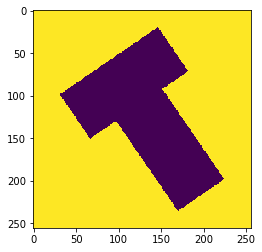

In [122]:
from matplotlib import pyplot as plt
plt.imshow(mask, interpolation='nearest')
plt.show()

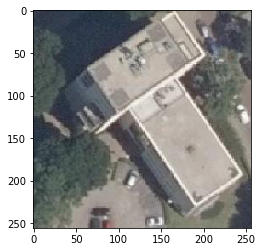

In [175]:
import skimage.io

def get_luchtfoto_rgb_array(bbox, resolution):
  endpoint = 'https://geodata.nationaalgeoregister.nl/luchtfoto/rgb/wms?'
  query = {
    'service': 'WMS',
    'version': '1.1.1',
    'request': 'GetMap',
    'format': 'image/png',
    'layers': 'Actueel_ortho25',
    'srs': 'EPSG:28992'
  }
  query['bbox'] = ','.join([str(x) for x in bbox])
  query['width'] = resolution[0]
  query['height'] = resolution[1]
  
  url = endpoint + urlencode(query)
  return skimage.io.imread(url)
  
luchtfoto = get_luchtfoto_rgb_array(bbox, resolution)
plt.imshow(luchtfoto, interpolation='nearest')
plt.show()


In [124]:
import keras

model = keras.models.load_model("../models/run3_rgb_19_256/")
model.input_shape, model.output_shape

((None, 256, 256, 3), (None, 246, 246, 1))

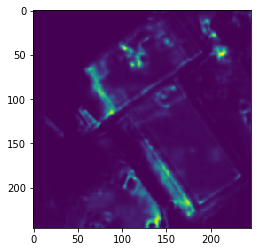

In [125]:
inp = np.expand_dims(luchtfoto, 0)/255.0
predict = model.predict(inp)
predict = predict[0,:,:,0]
plt.imshow(predict, interpolation='nearest')

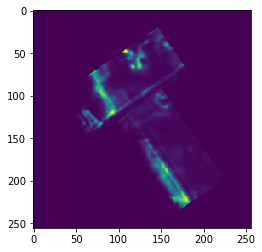

In [126]:
predict = np.pad(predict, pad_width=[(5, 5),(5, 5)], mode='constant')
predict = predict * np.invert(mask).astype(int)
plt.imshow(predict, interpolation='nearest')


1326


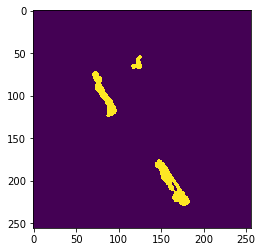

In [181]:
import skimage.filters

def filter_predict(predict, sigma=5):
    mask = skimage.filters.gaussian(predict, sigma=sigma)
    mask = mask > 0.3
    mask = skimage.filters.gaussian(mask, sigma=sigma)
    mask = mask > 0.02
    result = (predict * mask) > 0.3
    result = skimage.filters.gaussian(result, sigma=sigma/3)
    result = result > 0.45
    return result

filtered = filter_predict(predict, 5)
print(filtered.sum())
plt.imshow(filter_predict(predict, 5), interpolation='nearest')

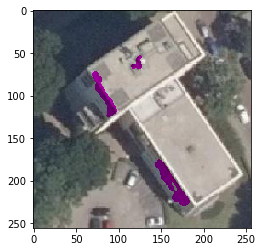

In [182]:
base = np.copy(luchtfoto)
base[:,:,1] *= np.invert(filtered)
plt.imshow(base, interpolation='nearest')